In [30]:
from pathlib import Path
import sys
import pandas as pd
from PIL import Image
import io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.model_selection import train_test_split
import torchvision 
from torchvision import transforms
import pickle
from scipy import stats
import numpy as np
from torchvision.models import efficientnet_b3
from torchcam.methods import SmoothGradCAMpp, CAM, GradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image
import torch.nn.functional as F

In [54]:
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return x * self.se(x)

In [67]:
class EfficientNetB3(nn.Module):
  def __init__(self, num_classes, stages):
    super(EfficientNetB3, self).__init__()
    self.model = efficientnet_b3(weights="IMAGENET1K_V1", progress=True)
    # self.model.classifier[1].out_features = num_classes
    self.model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),  # Dropout layer with 30% dropout rate
        nn.Linear(in_features=1536, out_features=num_classes, bias=True)  # Adjust in_features to match EfficientNetB3 output
    )

    for param in self.model.parameters():
        param.requires_grad = True
    for param in self.model.classifier.parameters():
        param.requires_grad = True
    # qse in stage 2
    if 2 in stages:
        self.model.features[1][0].block[1] = SqueezeExcitation(40,10)
        self.model.features[1][1].block[1] = SqueezeExcitation(24,6)
    # qse in stage 3
    if 3 in stages:
        self.model.features[2][0].block[2] = SqueezeExcitation(144,6)
        for i in range(1,3):
          self.model.features[2][1].block[2] = SqueezeExcitation(192,8)
    # qse in stage 4
    if 4 in stages:
      self.model.features[3][0].block[2] = SqueezeExcitation(192,8)
      for i in range(1,3):  
        self.model.features[3][i].block[2] = SqueezeExcitation(288,12)
    # qse in stage 5
    if 5 in stages:
      self.model.features[4][0].block[2] = SqueezeExcitation(288,12)
      for i in range(1,5):
        self.model.features[4][i].block[2] = SqueezeExcitation(576,24)
    # qse in stage 6
    if 6 in stages:
      self.model.features[5][0].block[2] = SqueezeExcitation(576,24)
      for i in range(1,5):
        self.model.features[5][i].block[2] = SqueezeExcitation(816,34)
    # qse in stage 7
    if 7 in stages:
      self.model.features[6][0].block[2] = SqueezeExcitation(816,34)
      for i in range(1,6):
        self.model.features[6][i].block[2] = SqueezeExcitation(1392,58)
    # qse in stage 8
    if 8 in stages:
      self.model.features[7][0].block[2] = SqueezeExcitation(1392,58)
      self.model.features[7][1].block[2] = SqueezeExcitation(2304,96)
  def forward(self, x):
    return self.model(x)

In [68]:
class QuadrantSqueezeExcitation(nn.Module):
  def __init__(self, in_channels, reduction_dim):
    super(QuadrantSqueezeExcitation, self).__init__()
    self.avgpool = nn.AdaptiveAvgPool2d((2,2))
    # self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=reduction_dim, kernel_size=(1,1), stride=(1,1))
    # self.conv2 = nn.Conv2d(in_channels=reduction_dim, out_channels=in_channels, kernel_size=(1,1), stride=(1,1))
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=reduction_dim, kernel_size=(1,1), stride=(1,1))
    self.conv2 = nn.Conv2d(in_channels=reduction_dim, out_channels=in_channels, kernel_size=(1,1), stride=(1,1))
    self.activation = nn.SiLU()
    self.scale_activation = nn.Sigmoid()
  def forward(self, x):
    residual = x.clone()
    b,c,h,w = x.size()
    x = self.avgpool(x)
    x = self.conv1(x)
    x = self.activation(x)
    x = self.conv2(x)
    x = self.scale_activation(x)
    # Apply scaling to the quadrants without additional cloning
    residual[:, :, 0:int(h/2), 0:int(w/2)] *= x[:, :, 0:1, 0:1]  # Top-left
    residual[:, :, 0:int(h/2), int(w/2):w] *= x[:, :, 0:1, 1:2]  # Top-right
    residual[:, :, int(h/2):h, 0:int(w/2)] *= x[:, :, 1:2, 0:1]  # Bottom-left
    residual[:, :, int(h/2):h, int(w/2):w] *= x[:, :, 1:2, 1:2]  # Bottom-right
    return residual

In [69]:
class EfficientNetB3QSE(nn.Module):
  def __init__(self, num_classes, stages):
    super(EfficientNetB3QSE, self).__init__()
    self.model = efficientnet_b3(weights="IMAGENET1K_V1", progress=True)
    self.model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),  # Dropout layer with 30% dropout rate
        nn.Linear(in_features=1536, out_features=num_classes, bias=True)  # Adjust in_features to match EfficientNetB3 output
    )
    for param in self.model.parameters():
        param.requires_grad = True
    for param in self.model.classifier.parameters():
        param.requires_grad = True
    # qse in stage 2
    if 2 in stages:
        self.model.features[1][0].block[1] = QuadrantSqueezeExcitation(40,10)
        self.model.features[1][1].block[1] = QuadrantSqueezeExcitation(24,6)
    # qse in stage 3
    if 3 in stages:
        self.model.features[2][0].block[2] = QuadrantSqueezeExcitation(144,6)
        for i in range(1,3):
          self.model.features[2][1].block[2] = QuadrantSqueezeExcitation(192,8)
    # qse in stage 4
    if 4 in stages:
      self.model.features[3][0].block[2] = QuadrantSqueezeExcitation(192,8)
      for i in range(1,3):  
        self.model.features[3][i].block[2] = QuadrantSqueezeExcitation(288,12)
    # qse in stage 5
    if 5 in stages:
      self.model.features[4][0].block[2] = QuadrantSqueezeExcitation(288,12)
      for i in range(1,5):
        self.model.features[4][i].block[2] = QuadrantSqueezeExcitation(576,24)
    # qse in stage 6
    if 6 in stages:
      self.model.features[5][0].block[2] = QuadrantSqueezeExcitation(576,24)
      for i in range(1,5):
        self.model.features[5][i].block[2] = QuadrantSqueezeExcitation(816,34)
    # qse in stage 7
    if 7 in stages:
      self.model.features[6][0].block[2] = QuadrantSqueezeExcitation(816,34)
      for i in range(1,6):
        self.model.features[6][i].block[2] = QuadrantSqueezeExcitation(1392,58)
    # qse in stage 8
    if 8 in stages:
      self.model.features[7][0].block[2] = QuadrantSqueezeExcitation(1392,58)
      self.model.features[7][1].block[2] = QuadrantSqueezeExcitation(2304,96)
  def forward(self, x):
    return self.model(x)

In [70]:
class MixedSEandQSE1(nn.Module):
  def __init__(self, in_channels, reduction_dim):
    super(MixedSEandQSE1, self).__init__()
    self.global_avgpool =  nn.AdaptiveAvgPool2d((1,1))
    self.quadrant_avgpool = nn.AdaptiveAvgPool2d((2,2))
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=(2, 1), dilation=2, groups=in_channels)
    self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=reduction_dim, kernel_size=(1,1), stride=(1,1))
    self.conv3 = nn.Conv2d(in_channels=reduction_dim, out_channels=in_channels, kernel_size=(1,1), stride=(1,1))
    self.activation = nn.SiLU()
    self.scale_activation = nn.Sigmoid()
  def forward(self, x):
    residual = x.clone()
    b,c,h,w = x.size()
    gap_out = F.interpolate(self.global_avgpool(x), size=(2, 2), mode='bilinear', align_corners=False)
    qap_out = self.quadrant_avgpool(x)
    stacked_feature_map = torch.cat((gap_out, qap_out), dim=2)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.activation(x)
    x = self.conv3(x)
    x = self.scale_activation(x)

    # Apply scaling to the quadrants without additional cloning
    residual[:, :, 0:int(h/2), 0:int(w/2)] *= x[:, :, 0:1, 0:1]  # Top-left
    residual[:, :, 0:int(h/2), int(w/2):w] *= x[:, :, 0:1, 1:2]  # Top-right
    residual[:, :, int(h/2):h, 0:int(w/2)] *= x[:, :, 1:2, 0:1]  # Bottom-left
    residual[:, :, int(h/2):h, int(w/2):w] *= x[:, :, 1:2, 1:2]  # Bottom-right
    return residual

In [71]:
class EfficientNetB3SEAndQSE1(nn.Module):
  def __init__(self, num_classes, stages):
    super(EfficientNetB3SEAndQSE1, self).__init__()
    self.model = efficientnet_b3(weights="IMAGENET1K_V1", progress=True)
    self.model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),  # Dropout layer with 30% dropout rate
        nn.Linear(in_features=1536, out_features=num_classes, bias=True)  # Adjust in_features to match EfficientNetB3 output
    )

    for param in self.model.parameters():
        param.requires_grad = True
    for param in self.model.classifier.parameters():
        param.requires_grad = True
    # qse in stage 2
    if 2 in stages:
        self.model.features[1][0].block[1] = MixedSEandQSE1(40,10)
        self.model.features[1][1].block[1] = MixedSEandQSE1(24,6)
    # qse in stage 3
    if 3 in stages:
        self.model.features[2][0].block[2] = MixedSEandQSE1(144,6)
        for i in range(1,3):
          self.model.features[2][1].block[2] = MixedSEandQSE1(192,8)
    # qse in stage 4
    if 4 in stages:
      self.model.features[3][0].block[2] = MixedSEandQSE1(192,8)
      for i in range(1,3):  
        self.model.features[3][i].block[2] = MixedSEandQSE1(288,12)
    # qse in stage 5
    if 5 in stages:
      self.model.features[4][0].block[2] = MixedSEandQSE1(288,12)
      for i in range(1,5):
        self.model.features[4][i].block[2] = MixedSEandQSE1(576,24)
    # qse in stage 6
    if 6 in stages:
      self.model.features[5][0].block[2] = MixedSEandQSE1(576,24)
      for i in range(1,5):
        self.model.features[5][i].block[2] = MixedSEandQSE1(816,34)
    # qse in stage 7
    if 7 in stages:
      self.model.features[6][0].block[2] = MixedSEandQSE1(816,34)
      for i in range(1,6):
        self.model.features[6][i].block[2] = MixedSEandQSE1(1392,58)
    # qse in stage 8
    if 8 in stages:
      self.model.features[7][0].block[2] = MixedSEandQSE1(1392,58)
      self.model.features[7][1].block[2] = MixedSEandQSE1(2304,96)
  def forward(self, x):
    return self.model(x)

In [72]:
class MixedSEandQSE2(nn.Module):
  def __init__(self, in_channels, reduction_dim):
    super(MixedSEandQSE2, self).__init__()
    self.global_avgpool =  nn.AdaptiveAvgPool2d((1,1))
    self.quadrant_avgpool = nn.AdaptiveAvgPool2d((2,2))
    self.w_gap = nn.Parameter(torch.tensor(0.5))  # Initialize both weights to 0.5
    self.w_qap = nn.Parameter(torch.tensor(0.5))
    self.fc = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=reduction_dim, kernel_size=(1,1), stride=(1,1)),
        nn.SiLU(),
        nn.Conv2d(in_channels=reduction_dim, out_channels=in_channels, kernel_size=(1,1), stride=(1,1))
    )
    self.scale_activation = nn.Sigmoid()
  def forward(self, x):
    residual = x.clone()
    b,c,h,w = x.size()
    gap_out = self.fc(self.global_avgpool(x).repeat(1,1,2,2))
    qap_out = self.fc(self.quadrant_avgpool(x))
    x = self.scale_activation(self.w_gap * gap_out + self.w_qap * qap_out)

    # Apply scaling to the quadrants without additional cloning
    residual[:, :, 0:int(h/2), 0:int(w/2)] *= x[:, :, 0:1, 0:1]  # Top-left
    residual[:, :, 0:int(h/2), int(w/2):w] *= x[:, :, 0:1, 1:2]  # Top-right
    residual[:, :, int(h/2):h, 0:int(w/2)] *= x[:, :, 1:2, 0:1]  # Bottom-left
    residual[:, :, int(h/2):h, int(w/2):w] *= x[:, :, 1:2, 1:2]  # Bottom-right
    return residual

In [73]:
class EfficientNetB3SEAndQSE2(nn.Module):
  def __init__(self, num_classes, stages):
    super(EfficientNetB3SEAndQSE2, self).__init__()
    self.model = efficientnet_b3(weights="IMAGENET1K_V1", progress=True)
    self.model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),  # Dropout layer with 30% dropout rate
        nn.Linear(in_features=1536, out_features=num_classes, bias=True)  # Adjust in_features to match EfficientNetB3 output
    )
    for param in self.model.parameters():
        param.requires_grad = False
    for param in self.model.classifier.parameters():
        param.requires_grad = True
    # qse in stage 2
    if 2 in stages:
        self.model.features[1][0].block[1] = MixedSEandQSE2(40,10)
        self.model.features[1][1].block[1] = MixedSEandQSE2(24,6)
    # qse in stage 3
    if 3 in stages:
        self.model.features[2][0].block[2] = MixedSEandQSE2(144,6)
        for i in range(1,3):
          self.model.features[2][1].block[2] = MixedSEandQSE2(192,8)
    # qse in stage 4
    if 4 in stages:
      self.model.features[3][0].block[2] = MixedSEandQSE2(192,8)
      for i in range(1,3):  
        self.model.features[3][i].block[2] = MixedSEandQSE2(288,12)
    # qse in stage 5
    if 5 in stages:
      self.model.features[4][0].block[2] = MixedSEandQSE2(288,12)
      for i in range(1,5):
        self.model.features[4][i].block[2] = MixedSEandQSE2(576,24)
    # qse in stage 6
    if 6 in stages:
      self.model.features[5][0].block[2] = MixedSEandQSE2(576,24)
      for i in range(1,5):
        self.model.features[5][i].block[2] = MixedSEandQSE2(816,34)
    # qse in stage 7
    if 7 in stages:
      self.model.features[6][0].block[2] = MixedSEandQSE2(816,34)
      for i in range(1,6):
        self.model.features[6][i].block[2] = MixedSEandQSE2(1392,58)
    # qse in stage 8
    if 8 in stages:
      self.model.features[7][0].block[2] = MixedSEandQSE2(1392,58)
      self.model.features[7][1].block[2] = MixedSEandQSE2(2304,96)
  def forward(self, x):
    return self.model(x)

In [74]:
class MixedSEandQSE3(nn.Module):
  def __init__(self, in_channels, reduction_dim):
    super(MixedSEandQSE3, self).__init__()
    self.global_avgpool =  nn.AdaptiveAvgPool2d((1,1))
    self.quadrant_avgpool = nn.AdaptiveAvgPool2d((2,2))
    self.fc = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=reduction_dim, kernel_size=(1,1), stride=(1,1)),
        nn.SiLU(),
        nn.Conv2d(in_channels=reduction_dim, out_channels=in_channels, kernel_size=(1,1), stride=(1,1))
    )
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=(2, 1), dilation=2, groups=in_channels)
    self.activation = nn.SiLU()
    self.scale_activation = nn.Sigmoid()
  def forward(self, x):
    residual = x.clone()
    b,c,h,w = x.size()
    gap_out = self.fc(self.global_avgpool(x).repeat(1,1,2,2))
    qap_out = self.fc(self.quadrant_avgpool(x))
    x = self.scale_activation(self.conv1(torch.cat((gap_out, qap_out), dim=2)))
    # Apply scaling to the quadrants without additional cloning
    residual[:, :, 0:int(h/2), 0:int(w/2)] *= x[:, :, 0:1, 0:1]  # Top-left
    residual[:, :, 0:int(h/2), int(w/2):w] *= x[:, :, 0:1, 1:2]  # Top-right
    residual[:, :, int(h/2):h, 0:int(w/2)] *= x[:, :, 1:2, 0:1]  # Bottom-left
    residual[:, :, int(h/2):h, int(w/2):w] *= x[:, :, 1:2, 1:2]  # Bottom-right
    return residual

In [75]:
class EfficientNetB3SEAndQSE3(nn.Module):
  def __init__(self, num_classes, stages):
    super(EfficientNetB3SEAndQSE3, self).__init__()
    self.model = efficientnet_b3(weights="IMAGENET1K_V1", progress=True)
    self.model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),  # Dropout layer with 30% dropout rate
        nn.Linear(in_features=1536, out_features=num_classes, bias=True)  # Adjust in_features to match EfficientNetB3 output
    )
    for param in self.model.parameters():
        param.requires_grad = False
    for param in self.model.classifier.parameters():
        param.requires_grad = True
    # qse in stage 2
    if 2 in stages:
        self.model.features[1][0].block[1] = MixedSEandQSE3(40,10)
        self.model.features[1][1].block[1] = MixedSEandQSE3(24,6)
    # qse in stage 3
    if 3 in stages:
        self.model.features[2][0].block[2] = MixedSEandQSE3(144,6)
        for i in range(1,3):
          self.model.features[2][1].block[2] = MixedSEandQSE3(192,8)
    # qse in stage 4
    if 4 in stages:
      self.model.features[3][0].block[2] = MixedSEandQSE3(192,8)
      for i in range(1,3):  
        self.model.features[3][i].block[2] = MixedSEandQSE3(288,12)
    # qse in stage 5
    if 5 in stages:
      self.model.features[4][0].block[2] = MixedSEandQSE3(288,12)
      for i in range(1,5):
        self.model.features[4][i].block[2] = MixedSEandQSE3(576,24)
    # qse in stage 6
    if 6 in stages:
      self.model.features[5][0].block[2] = MixedSEandQSE3(576,24)
      for i in range(1,5):
        self.model.features[5][i].block[2] = MixedSEandQSE3(816,34)
    # qse in stage 7
    if 7 in stages:
      self.model.features[6][0].block[2] = MixedSEandQSE3(816,34)
      for i in range(1,6):
        self.model.features[6][i].block[2] = MixedSEandQSE3(1392,58)
    # qse in stage 8
    if 8 in stages:
      self.model.features[7][0].block[2] = MixedSEandQSE3(1392,58)
      self.model.features[7][1].block[2] = MixedSEandQSE3(2304,96)
  def forward(self, x):
    return self.model(x)

In [76]:
num_classes = 31
stages = [2,3,4,5,6,7,8]
efficientnet_b3_basic = EfficientNetB3(num_classes, stages)
efficientnet_b3_qse = EfficientNetB3QSE(num_classes, stages)
efficientnet_b3_mixedseqse_1 = EfficientNetB3SEAndQSE1(num_classes, stages)
efficientnet_b3_mixedseqse_2 = EfficientNetB3SEAndQSE2(num_classes, stages)
efficientnet_b3_mixedseqse_3 = EfficientNetB3SEAndQSE3(num_classes, stages)

In [80]:
efficientnet_b3_basic.load_state_dict(torch.load("../efficientnet_b3_basic/2080_split/best_model_parameters.pth", weights_only=True))
efficientnet_b3_qse.load_state_dict(torch.load("../efficientnet_b3_qse_avg/2080_split/stage2_stage3_stage4_stage5_stage5_stage7_stage8/best_model_parameters.pth", weights_only=True))
efficientnet_b3_mixedseqse_1.load_state_dict(torch.load("../efficientnet_b3_se_qse_1/2080_split/stage2_stage3_stage4_stage5_stage6_stage7_stage8/best_model_parameters.pth", weights_only=True))
efficientnet_b3_mixedseqse_2.load_state_dict(torch.load("../efficientnet_b3_se_qse_2/2080_split/stage2_stage3_stage4_stage5_stage6_stage7_stage8/best_model_parameters.pth", weights_only=True))
efficientnet_b3_mixedseqse_3.load_state_dict(torch.load("../efficientnet_b3_se_qse_3/2080_split/stage2_stage3_stage4_stage5_stage6_stage7_stage8/best_model_parameters.pth", weights_only=True))

<All keys matched successfully>

In [81]:
efficientnet_b3_basic.eval()
efficientnet_b3_qse.eval()
efficientnet_b3_mixedseqse_1.eval()
efficientnet_b3_mixedseqse_2.eval()
efficientnet_b3_mixedseqse_3.eval()
print()

In [82]:
df = pd.read_parquet("hf://datasets/jonathan-roberts1/WHU-RS19/data/train-00000-of-00001-bc192ed023be1f72.parquet")
df = pd.read_parquet("hf://datasets/jonathan-roberts1/Optimal-31/data/train-00000-of-00001-6f3929acf058ef6f.parquet")

In [83]:
label = {
    0:"meadow",
    1:"beach",
    2:"bridge",
    3:"commercial",
    4:"desert",
    5:"farmland",
    6:"football field",
    7:"forest",
    8:"industrial",
    9:"meadow",
    10:"mountain",
    11:"park",
    12:"parking",
    13:"pond",
    14:"port",
    15:"railway station",
    16:"residential",
    17:"river",
    18:"viaduct"
}

label = {
    0: "airplane",
    1: "airport",
    2: "baseball diamond",
    3: "basketball court",
    4: "beach",
    5: "bridge",
    6: "chaparral",
    7: "church",
    8: "circular farmland",
    9: "commercial area",
    10: "dense residential", 
    11: "desert",
    12: "forest", 
    13: "freeway",
    14: "golf course",
    15: "ground track field", 
    16: "harbor",
    17: "industrial area", 
    18: "intersection", 
    19: "island", 
    20: "lake",
    21: "meadow", 
    22: "medium residential", 
    23: "mobile home park",
    24: "mountain",
    25: "overpass",
    26: "parking lot", 
    27: "railway",
    28: "rectangular farmland",
    29: "roundabout",
    30: "runway"
}

In [84]:
df.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [85]:
def bytes_to_image(byte_data):
    image = Image.open(io.BytesIO(byte_data["bytes"]))  # Convert bytes to PIL image
    return image

df["image"] = df["image"].apply(bytes_to_image)
df.head()

,image,label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0


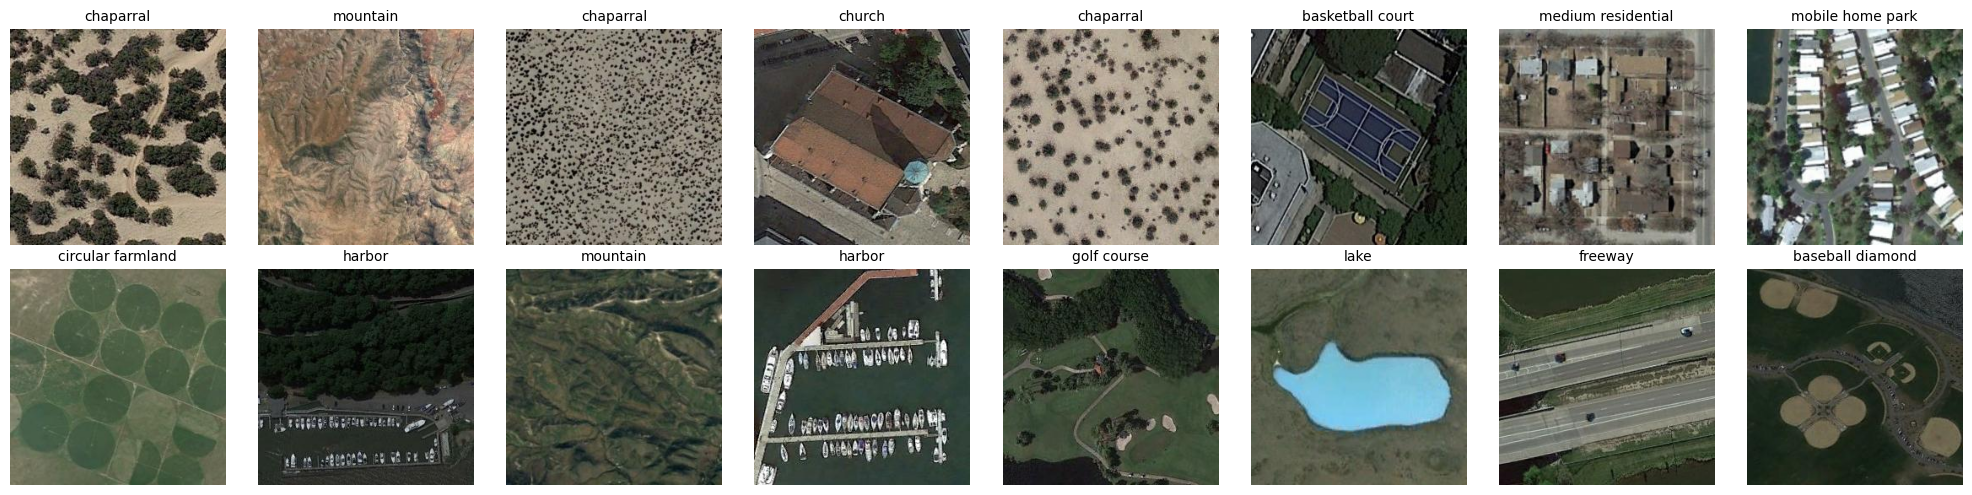

In [86]:
sampled_df = df.sample(n=16)
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
axes = axes.ravel()
for i, (index, row) in enumerate(sampled_df.iterrows()):
    img = row['image']
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(label[row['label']], fontsize=10)  
plt.tight_layout()
plt.show()

In [87]:
optimal_31_label = {
    0: "airplane",
    1: "airport",
    2: "baseball diamond",
    3: "basketball court",
    4: "beach",
    5: "bridge",
    6: "chaparral",
    7: "church",
    8: "circular farmland",
    9: "commercial area",
    10: "dense residential", 
    11: "desert",
    12: "forest", 
    13: "freeway",
    14: "golf course",
    15: "ground track field", 
    16: "harbor",
    17: "industrial area", 
    18: "intersection", 
    19: "island", 
    20: "lake",
    21: "meadow", 
    22: "medium residential", 
    23: "mobile home park",
    24: "mountain",
    25: "overpass",
    26: "parking lot", 
    27: "railway",
    28: "rectangular farmland",
    29: "roundabout",
    30: "runway"
}

In [138]:
img = df[df['label'] == 19].sample(n=1)["image"].values[0]
resize = transforms.Resize((256, 256))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
input_tensor = normalize(to_tensor(resize(img)))

Prediction: island


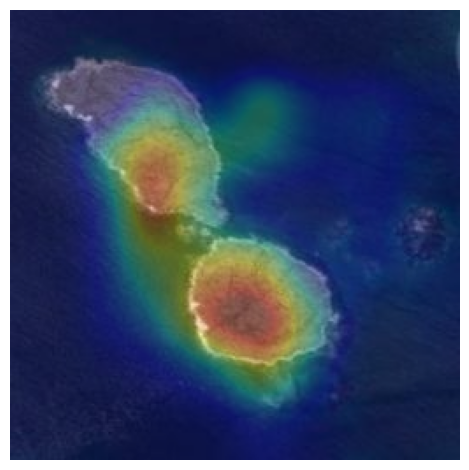

In [139]:
with GradCAMpp(efficientnet_b3_basic, target_layer=efficientnet_b3_basic.model.features[-1]) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = efficientnet_b3_basic(input_tensor.unsqueeze(0))
  # Retrieve the CAM by passing the class index and the model output
  print(f"Prediction: {optimal_31_label[out.squeeze(0).argmax().item()]}")
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
result = overlay_mask(to_pil_image(to_tensor(img)), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.7)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

Prediction: island


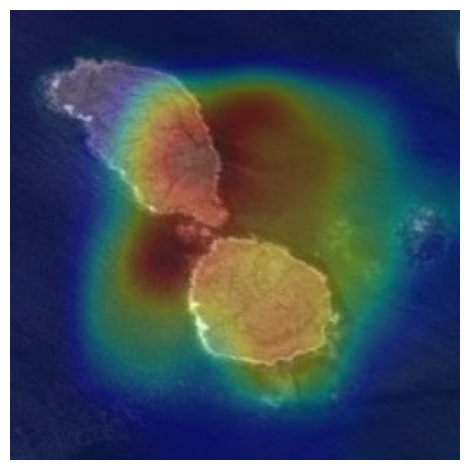

In [140]:
with GradCAMpp(efficientnet_b3_qse, target_layer=efficientnet_b3_qse.model.features[-1]) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = efficientnet_b3_qse(input_tensor.unsqueeze(0))
  # Retrieve the CAM by passing the class index and the model output
  print(f"Prediction: {optimal_31_label[out.squeeze(0).argmax().item()]}")
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
result = overlay_mask(to_pil_image(to_tensor(img)), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.7)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

Prediction: island


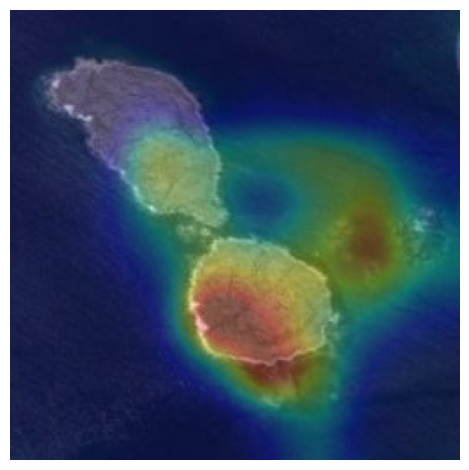

In [141]:
with GradCAMpp(efficientnet_b3_mixedseqse_1, target_layer=efficientnet_b3_mixedseqse_1.model.features[-1]) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = efficientnet_b3_mixedseqse_1(input_tensor.unsqueeze(0))
  # Retrieve the CAM by passing the class index and the model output
  print(f"Prediction: {optimal_31_label[out.squeeze(0).argmax().item()]}")
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
result = overlay_mask(to_pil_image(to_tensor(img)), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.7)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

Prediction: island


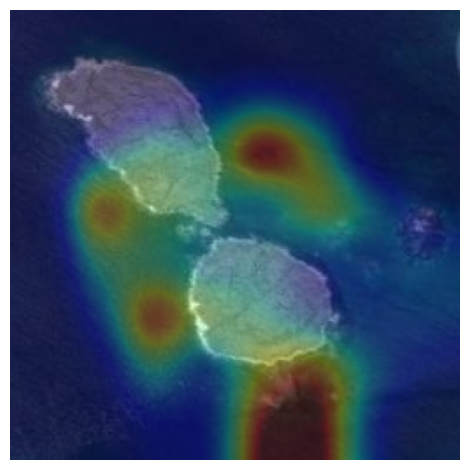

In [142]:
with GradCAMpp(efficientnet_b3_mixedseqse_2, target_layer=efficientnet_b3_mixedseqse_2.model.features[-1]) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = efficientnet_b3_mixedseqse_2(input_tensor.unsqueeze(0))
  # Retrieve the CAM by passing the class index and the model output
  print(f"Prediction: {optimal_31_label[out.squeeze(0).argmax().item()]}")
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
result = overlay_mask(to_pil_image(to_tensor(img)), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.7)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

Prediction: island


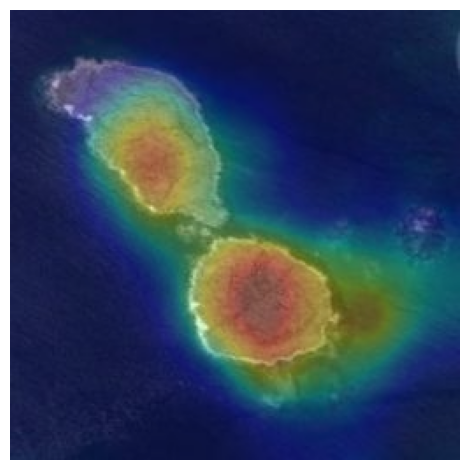

In [143]:
with GradCAMpp(efficientnet_b3_mixedseqse_3, target_layer=efficientnet_b3_mixedseqse_3.model.features[-1]) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = efficientnet_b3_mixedseqse_3(input_tensor.unsqueeze(0))
  # Retrieve the CAM by passing the class index and the model output
  print(f"Prediction: {optimal_31_label[out.squeeze(0).argmax().item()]}")
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
result = overlay_mask(to_pil_image(to_tensor(img)), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.7)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()